# ✈️✈️✈️ End-to-end Multi-class Military Aircraft Detection Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2 Object Detection API to train an SSD-MobileNet model or EfficientDet model with a custom dataset and convert it to TensorFlow Lite format.

Proceedure Roadmap:
When multiple annotated subjects in a single image, I am dealing with a multi-object detection problem. Here's a general approach to prepare the dataset for train split testing:

* Annotation: Each individual object in an image should be labeled separately. You'll want to create "bounding boxes" around each object in an image, and then label that box with the type of aircraft it contains. Tools like Labelbox, LabelImg, or VGG Image Annotator (VIA) can help with this process.

* Format the Data: Your labels should include not only the type of aircraft, but also the location of the bounding box within the image. These labels are usually saved in a structured format such as XML or JSON. For example, in TensorFlow's Object Detection API, they use the TFRecord format.

* Model Selection: You'll want to choose a model architecture that's designed for object detection. Some examples include Single Shot MultiBox Detector (SSD), Region-CNN (R-CNN), and You Only Look Once (YOLO).

* Training: When you train your model, it will learn to not only classify different types of aircraft but also to predict the bounding boxes around them in the image.

* Evaluation: Finally, you'll want to choose an appropriate evaluation metric. For multi-object detection tasks, mean Average Precision (mAP) is often used.

## 1. Problem

Identifying the type of airplain given an image of a aircraft.

When I take a photo of an airplane, I want to know what types of airplain and the number of airplane is in the photo.

## 2. Data

The data we're using is from Kaggle's "Military Aircraft Detection Dataset"

https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset

* After downloading the file onto local HD, I seperate the labeled csv file by concatenate all the labeled datasets into one `combined.csv` dataset.
* Start upload all the images + `combined.csv` onto Google Drive
* Applied the bounding boxes from the `combined.csv` onto the image sample dataset

## 3. Evaluation

The evaluation is a file with prediction probobilities for each aircraft of each test image.

## 4. Dataset Features

* The dataset contain images with multiple and corrispnding labeling .csv files with the same file names.
* Each fragmented labeling csv file has precised x & y axis of value that can be used as the 4 corners bounding boxes for designated training areas for machines to learn.
* We are annotating the image samples with the provided xy axieses on each of the corrisponding labels (csv).
* There are 43 types of aircrafts (classes) for machine to learn.
* There are 10k+ samples total for further train-split-test modeling.

## 2. Install TensorFlow Object Detection Dependencies

First, we'll install the TensorFlow Object Detection API in this Google Colab instance. This requires cloning the [TensorFlow models repository](https://github.com/tensorflow/models) and running a couple installation commands. Click the play button to run the following sections of code.


In [16]:
# Clone the tensorflow models repository from GitHub
!git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [6]:
# Copy setup files into models/research folder
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
#cp object_detection/packages/tf2/setup.py .

In [1]:
# Import packages
import os
import cv2
import numpy as np
import sys
import glob
import random
import importlib.util
from tensorflow.lite.python.interpreter import Interpreter
import pandas as pd
from google.colab.patches import cv2_imshow

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
# Modify setup.py file to install the tf-models-official repository targeted at TF v2.8.0
import re
with open('/content/models/research/object_detection/packages/tf2/setup.py') as f:
    s = f.read()

with open('/content/models/research/setup.py', 'w') as f:
    # Set fine_tune_checkpoint path
    s = re.sub('tf-models-official>=2.5.1',
               'tf-models-official==2.8.0', s)
    f.write(s)

In [8]:
# Install the Object Detection API
!pip install /content/models/research/

# Need to downgrade to TF v2.8.0 due to Colab compatibility bug with TF v2.10 (as of 10/03/22)
!pip install tensorflow==2.8.0

Processing ./models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 42.6 MB/s et

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 26.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.1
    Uninstalling tensorflow-2.8.1:
      Successfully uninstalled tensorflow-2.8.1


Let's test our installation by running `model_builder_tf2_test.py` to make sure everything is working as expected. Run the following code block and confirm that it finishes without errors. If you get errors, try Googling them or checking the FAQ at the end of this Colab.

In [9]:
# Run Model Bulider Test file, just to verify everything's working properly
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.10/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZNK10tensorflow4data11DatasetBase8FinalizeEPNS_15OpKernelContextESt8functionIFN3tsl8StatusOrISt10u

### Image and Labeling Data prep work
I want to test out the labeling data with the corresponding file name and place bounding boxes as preview to check for the authenticity. The following info is added to the image dataset:

* bounding boxes
* `class` labeling value added to the bounding boxes

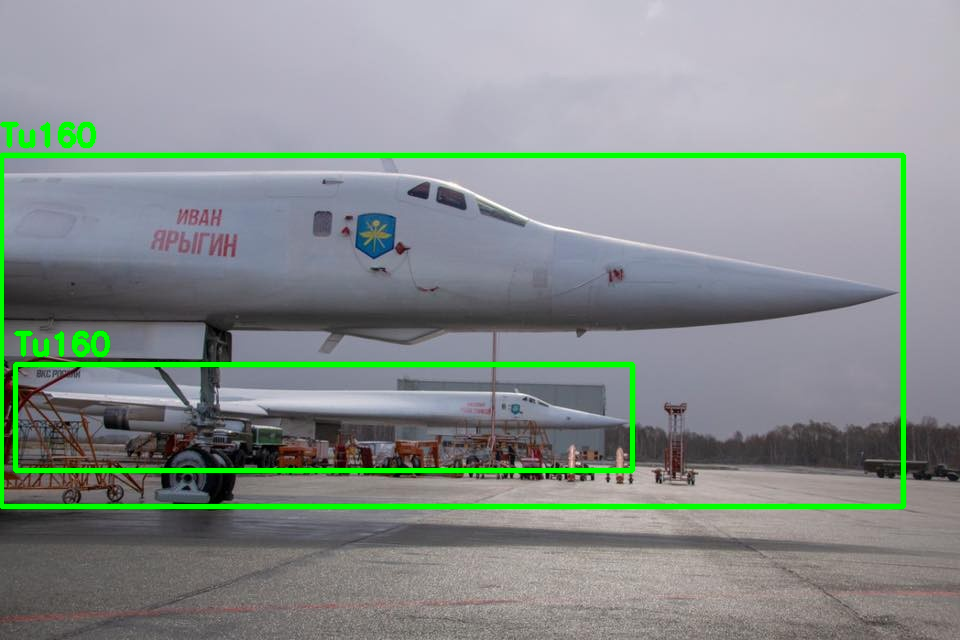

In [7]:
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow

# Read the CSV file
df_testing = pd.read_csv('drive/MyDrive/Military Aircraft Recognition/combined.csv')

# Filter the rows related to the image
df_img = df_testing[df_testing['filename'] == '0a2a11a8658d69b6cd1fd23c5f4513bd']

# Read the image once
image_path = 'drive/MyDrive/Military Aircraft Recognition/0a2a11a8658d69b6cd1fd23c5f4513bd.jpg'
image = cv2.imread(image_path)

# Check if the image is correctly loaded
if image is None:
    print(f"No image found at {image_path}")
else:
    # Loop through each row in the filtered dataframe
    for index, row in df_img.iterrows():
        # Get the bounding box coordinates
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])

        # Get the class label
        label = str(row['class'])

        # Draw the bounding box and the label on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        cv2.putText(image, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    # Display the image with all bounding boxes
    cv2_imshow(image)

### Labeling DataSet Prep work

I need to concatenate all the labeling CSV files from scattered pieces into one unified labeling dataset as "Combined.csv".

In [8]:
import os

# specify the directory you're starting from
rootDir = 'drive/MyDrive/Military Aircraft Recognition'

# create an empty list to store all dataframes
all_dfs = []

# iterate through all files in the directory
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        # check if the file is a csv file
        if fname.endswith('.csv'):
            # create a dataframe from the csv file and append it to the list
            df = pd.read_csv(os.path.join(dirName, fname))
            all_dfs.append(df)

# concatenate all dataframes in the list
combined_df = pd.concat(all_dfs, ignore_index=True)

# save the combined dataframe to a csv file
combined_df.to_csv(os.path.join(rootDir, 'combined.csv'), index=False)

combined_df.head

<bound method NDFrame.head of                                filename  width  height  class  xmin  ymin  \
0      5dc92840a1c2570658f210118ee712af   4096    2730    F15   253  1070   
1      5dc92840a1c2570658f210118ee712af   4096    2730    F15  1680   908   
2      ce0ef7f5181357f27e09a98f4f07aa26   1600    1075   SR71   216   345   
3      769c27a7b2c804a73458175fd13a3a53    916     316    J20   303   183   
4      ac6c99e73c2b4a6af7a9d46b7209bd32   6016    4016     F4     1  1759   
...                                 ...    ...     ...    ...   ...   ...   
35550  0a36e5862664eb92575949fc3ce7f842    900     600  Mig31   441   291   
35551  b6b6185ac1d0e018eb35bc8a02ca9873   1752     986   F117   667   227   
35552  313d6f38ab74d109dddb5efd382aeacb   1000     563     C2   453   210   
35553  059843e8192d9e4e990da370775e1b53   1600     900    F18   213   200   
35554  6d761316b0a4b33dab3ebcf386f5f184   7360    4912     E2  2448  1605   

       xmax  ymax  
0      2275  1627  
1    

In [9]:
# Drop all scattered labeling datasets leaving only the combined labeling dataset
directory = 'drive/MyDrive/Military Aircraft Recognition'

for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename != "combined.csv":
        os.remove(os.path.join(directory, filename))

In [3]:
import os

# directory path
directory = 'drive/MyDrive/Military Aircraft Recognition'

# iterate over all the csv files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # strip off the .csv from the filename
        base_name = os.path.splitext(filename)[0]

        # check if corresponding jpg file exists
        if not os.path.exists(os.path.join(directory, base_name + '.jpg')):
            # if not, delete the csv file
            os.remove(os.path.join(directory, filename))

print("Task completed. All CSV files without corresponding JPG files have been removed.")


Task completed. All CSV files without corresponding JPG files have been removed.


#### For the dataset prepping purposes, I had to modify the labeling dataset by putting back the scattered csv labeling to make sure the Train-Split-Test machine leaning model works

In [4]:
import os

# directory path
directory = 'drive/MyDrive/Military Aircraft Recognition'

# initialize counters
num_csv_files = 0
num_jpg_files = 0

# iterate over all files in the directory
for filename in os.listdir(directory):
    # increment counters based on file extension
    if filename.endswith('.csv'):
        num_csv_files += 1
    elif filename.endswith('.jpg'):
        num_jpg_files += 1

print(f"Number of CSV files: {num_csv_files}")
print(f"Number of JPG files: {num_jpg_files}")


Number of CSV files: 9483
Number of JPG files: 9484


In [12]:
import os

directory = 'drive/MyDrive/Military Aircraft Recognition'

# initialize sets for filenames without extension
csv_files = set()
jpg_files = set()

# iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        csv_files.add(filename[:-4])  # remove file extension
    elif filename.endswith('.jpg'):
        jpg_files.add(filename[:-4])  # remove file extension

# find jpg files without a corresponding csv file
jpg_without_csv = jpg_files - csv_files

print(f"JPG files without a corresponding CSV: {jpg_without_csv}")


JPG files without a corresponding CSV: set()


In [14]:
# directory path
directory = 'drive/MyDrive/Military Aircraft Recognition'

# initialize counters
num_csv_files = 0
num_jpg_files = 0

# iterate over all files in the directory
for filename in os.listdir(directory):
    # increment counters based on file extension
    if filename.endswith('.csv'):
        num_csv_files += 1
    elif filename.endswith('.jpg'):
        num_jpg_files += 1

print(f"Number of CSV files: {num_csv_files}")
print(f"Number of JPG files: {num_jpg_files}")

Number of CSV files: 9484
Number of JPG files: 9484


### Apply the `Combined.csv` dataset for the image annotation labeling to all images samples

I want to use the combined.csv labeling dataset as the annotation bounding box under the "xmin, xmax, ymin, ymax" columns, and column "class" for labeling next to the bounding boxes for all the images dataset inside the same directory. Here is the following code so far:

In [8]:
# Read the CSV file
df_testing = pd.read_csv('drive/MyDrive/Military Aircraft Recognition/combined.csv')

df_testing.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax
34057,0a36e5862664eb92575949fc3ce7f842,900,600,Mig31,441,291,753,370
34058,b6b6185ac1d0e018eb35bc8a02ca9873,1752,986,F117,667,227,905,451
34059,313d6f38ab74d109dddb5efd382aeacb,1000,563,C2,453,210,896,376
34060,059843e8192d9e4e990da370775e1b53,1600,900,F18,213,200,576,463
34061,6d761316b0a4b33dab3ebcf386f5f184,7360,4912,E2,2448,1605,4779,3179


Check for the plotlib graphs for the qty per each classes

<Axes: >

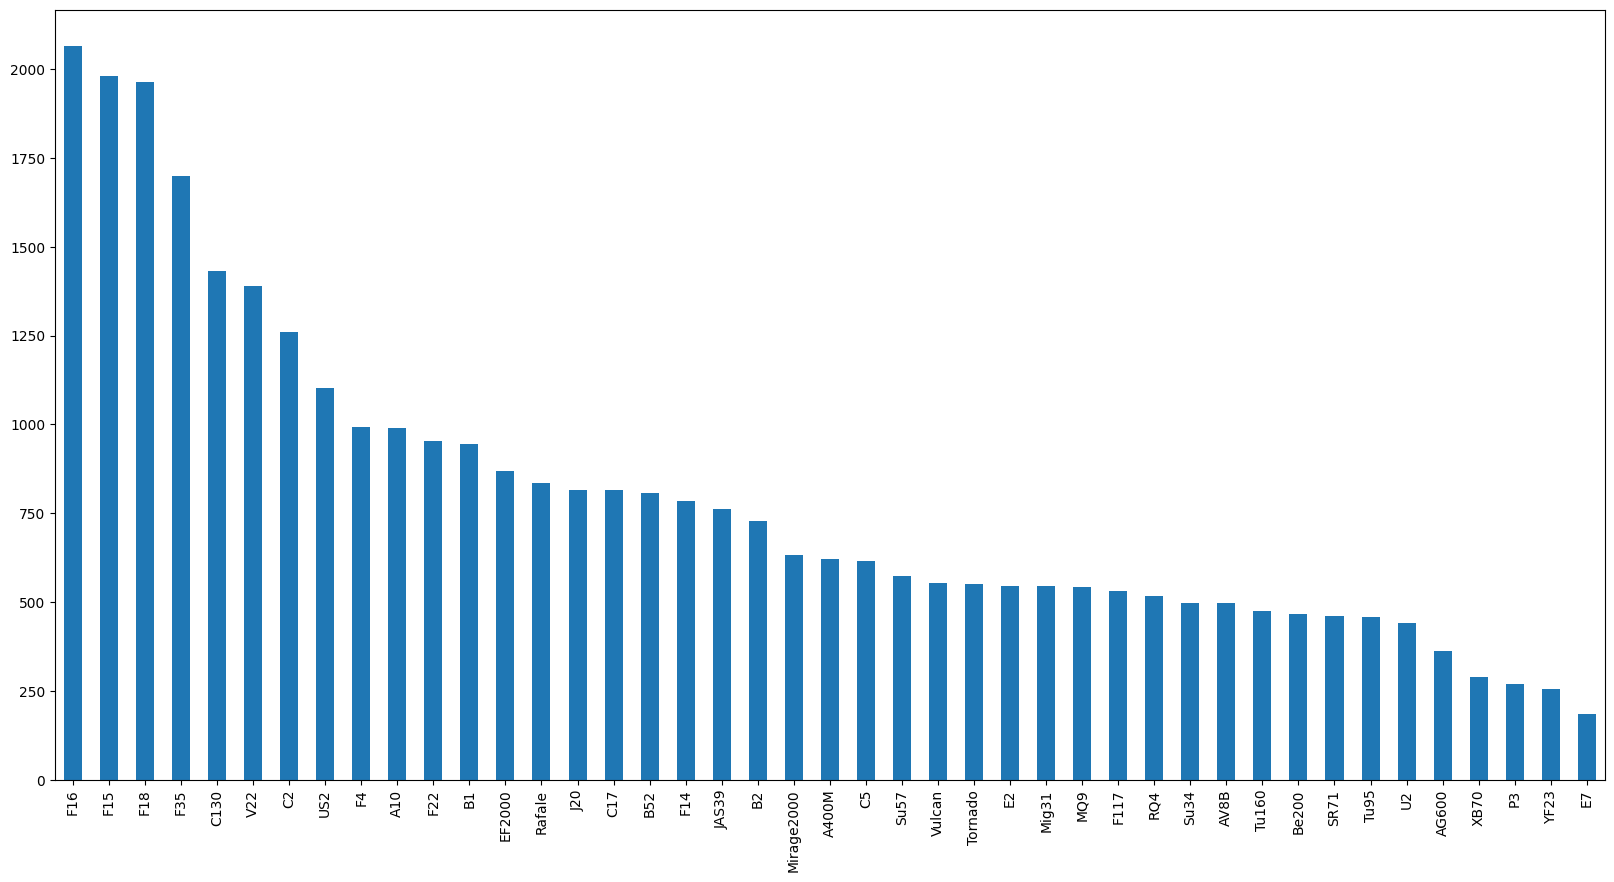

In [9]:
# How many images are there of each class?
df_testing["class"].value_counts().plot.bar(figsize=(20, 10))

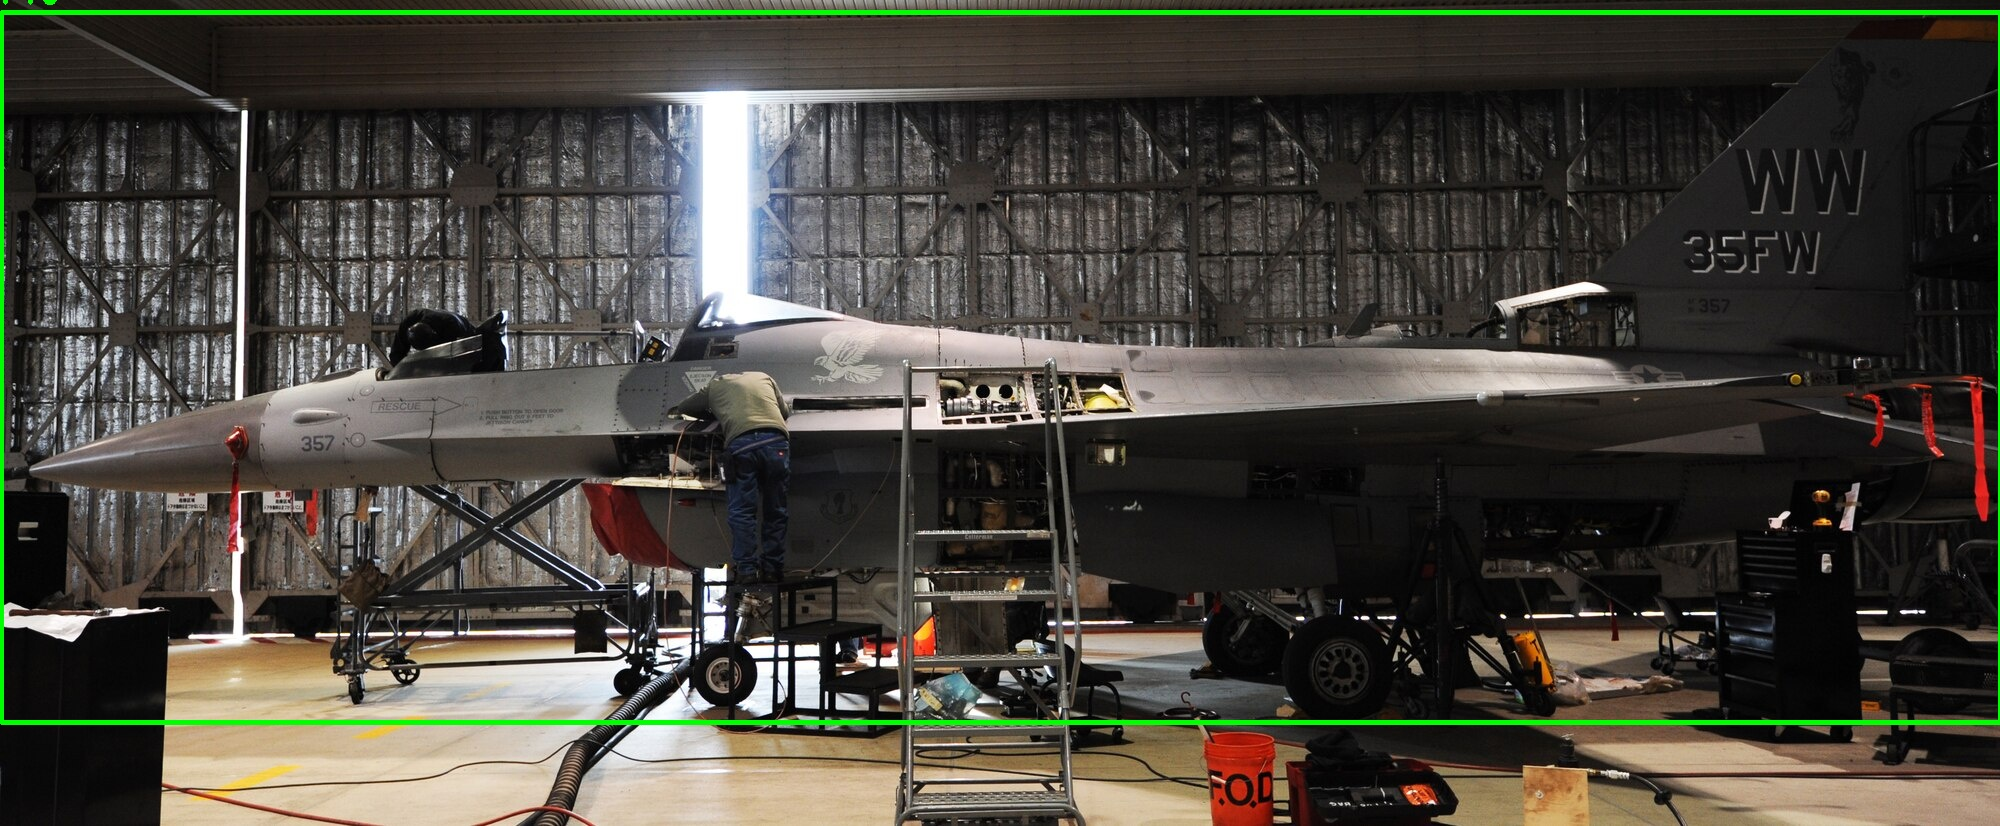

In [10]:
# let's view an image
from IPython.display import Image
Image('drive/MyDrive/Military Aircraft Recognition/82265f597e80518a4554b0938783d2df.jpg')

### At this point, the image sample dataset flooded my Google Drive

The dataset is simply TOO big for the cloud drive to hold all the image sample dataset

In [13]:
# Set the directory you want to start from
rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Set the file size limit (in bytes)
size_limit = 3 * 1024 * 1024  # 3 MB

# Walk through all files and subdirectories in the directory
for dirpath, dirs, files in os.walk(rootDir):
    for filename in files:
        file_path = os.path.join(dirpath, filename)
        # Get file size
        file_size = os.path.getsize(file_path)
        # If file size is greater than limit, delete the file
        if file_size > size_limit:
            os.remove(file_path)
            print(f'{file_path} removed')

Make sure the number of the image samples is correct in the directory

In [13]:
# Specify the directory
dir_path = 'drive/MyDrive/Military Aircraft Recognition'

# Get a list of all files and directories in the specified directory
files = os.listdir(dir_path)

# Use a list comprehension to filter out directories, leaving only files
files = [f for f in files if os.path.isfile(os.path.join(dir_path, f))]

# Print the number of files
print(len(files))

10683


#### need to count the amount of duplicated files by filename in a directory

In [15]:
import os
from collections import Counter

# Set the directory you want to start from
rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Get list of all files
file_list = []
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        file_list.append(fname)

# Count the frequency of each file
counter = Counter(file_list)

# Find duplicates
duplicates = {file: count for file, count in counter.items() if count > 1}

if len(duplicates) > 0:
    print(f"Found {len(duplicates)} duplicate files.")
else:
    print("No duplicate files found.")

No duplicate files found.


Lets see how many images sample files that is missing from the directory

In [16]:
# Get all the filenames from the directory (without extensions)
dir_filenames = [os.path.splitext(f)[0] for f in os.listdir('drive/MyDrive/Military Aircraft Recognition/') if f.endswith('.jpg') or f.endswith('.jpeg')]

# Get all the filenames from the CSV
csv_filenames = df['filename'].unique()

# Find the filenames in the CSV that are not in the directory
missing_files = [f for f in csv_filenames if f not in dir_filenames]

# Print or return the missing filenames
print(len(missing_files))

0


Also show the sizes of the directory

In [17]:
def get_dir_size(path='.'):
    total = 0
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_file():
                total += entry.stat().st_size
            elif entry.is_dir():
                total += get_dir_size(entry.path)
    return total

# Replace 'your_directory_path' with the actual path
directory_path = 'drive/MyDrive/Military Aircraft Recognition/'
total_size = get_dir_size(directory_path)

print(f'Total size of directory "{directory_path}" is {total_size / (1024 * 1024):.2f} MB')

Total size of directory "drive/MyDrive/Military Aircraft Recognition/" is 4597.18 MB


#### Clean the labeling dataset to match with the total amount of the sample image dataset in the directory

and resave it to a new labeling dataset

In [18]:
# Set the directory you want to start from
rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Collect all filenames
filenames = [os.path.splitext(f)[0] for f in os.listdir(rootDir) if f.endswith('.jpg')]

# Read the combined CSV file
df = pd.read_csv(os.path.join(rootDir, 'combined.csv'))

# Filter the dataframe to keep only rows where 'filename' is in the list of image filenames
df = df[df['filename'].isin(filenames)]

# Save the filtered dataframe back to the combined CSV file
df.to_csv(os.path.join(rootDir, 'combined.csv'), index=False)

Double check the total rows of sample for the "updated_combined.csv" labeling dataset

In [19]:
print(len(df))

34062


In [20]:
# Filter rows where 'filename' column contains the string '0a2a11a8658d69b6cd1fd23c5f4513bd'
df_filtered = df_testing[df_testing['filename'] == '0a2a11a8658d69b6cd1fd23c5f4513bd']

# Display the filtered DataFrame
print(df_filtered)

                               filename  width  height  class  xmin  ymin  \
15467  0a2a11a8658d69b6cd1fd23c5f4513bd    960     640  Tu160     1   155   
15468  0a2a11a8658d69b6cd1fd23c5f4513bd    960     640  Tu160    15   364   
32674  0a2a11a8658d69b6cd1fd23c5f4513bd    960     640  Tu160     1   155   
32675  0a2a11a8658d69b6cd1fd23c5f4513bd    960     640  Tu160    15   364   

       xmax  ymax  
15467   903   506  
15468   632   470  
32674   903   506  
32675   632   470  


### Try to access the combined dataset labels with rows corresponding to the image sample

lets try to show the first 5 sample rows according to the label dataset

In [21]:
# Assuming you have a dataframe df_combined
unique_filenames = df_testing['filename'].unique()

# Process only the first 5 unique images
for filename in unique_filenames[:10]:
    df_img = df_testing[df_testing['filename'] == filename]

    # Read the image once
    image_path = f'drive/MyDrive/Military Aircraft Recognition/{filename}.jpg'
    image = cv2.imread(image_path)

    # Check if the image is correctly loaded
    if image is None:
        print(f"No image found at {image_path}")
        continue

    # Loop through each row in the filtered dataframe
    for index, row in df_img.iterrows():
        # Get the bounding box coordinates
        xmin = int(row['xmin'])
        ymin = int(row['ymin'])
        xmax = int(row['xmax'])
        ymax = int(row['ymax'])

        # Get the class label
        label = str(row['class'])

        # Draw the bounding box and the label on the image
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
        cv2.putText(image, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

    # Display the image with all bounding boxes
    cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.

## Saving the image samples with bounding boxes labeled from combined.csv

Due to the Google Drive space constrain, I have to write over the exisiting image files with the new versions of image plus bounding boxes without making duplication of all the dataset

Before we committ the time into the `imwrite` pasting over the exisiting

In [26]:
import time

rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Read the combined CSV file
df = pd.read_csv(os.path.join(rootDir, 'combined.csv'))

# Determine the number of rows in your CSV
total_rows = len(df)

# Determine the number of images you want to process for the time estimation
num_images_for_test = 5000

start_time = time.time()

# Perform your operation on a subset of your data
for _, row in df.head(num_images_for_test).iterrows():
    image_filename = row['filename']
    image = cv2.imread(os.path.join(rootDir, image_filename + '.jpg'))

    # If image file not found, continue with next iteration
    if image is None:
        continue

    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)

end_time = time.time()

# Calculate elapsed time for the test
elapsed_time_test = end_time - start_time

# Extrapolate this to your full dataset
estimated_time_full_dataset = (elapsed_time_test / num_images_for_test) * total_rows

print(f"Estimated time for full dataset: {estimated_time_full_dataset} seconds")


Estimated time for full dataset: 3822.078399815083 seconds


Seems like the progress of bounding box label is not complete. I need to check how many are not being labeled so far.

In [12]:
import cv2
import numpy as np

# Set the bounding box color
bbox_color = [0, 255, 0]  # RGB for green

# Initialize a counter for images without bounding boxes
counter_no_bbox = 0

# Go through all unique image filenames
for filename in unique_filenames:
    image_path = f'drive/MyDrive/Military Aircraft Recognition/{filename}.jpg'
    image = cv2.imread(image_path)

    # Check if the image is correctly loaded
    if image is None:
        print(f"No image found at {image_path}")
        continue

    # Create a mask for pixels that match the bounding box color
    mask = np.all(image == bbox_color, axis=-1)

    # Now 'mask' is a 2D array where True indicates a bounding box pixel
    # Count the number of True values to see how many bounding box pixels there are
    bbox_pixel_count = np.count_nonzero(mask)

    # If bbox_pixel_count is zero, the image does not have a bounding box
    if bbox_pixel_count == 0:
        counter_no_bbox += 1

print(f"Number of images without bounding boxes: {counter_no_bbox}")


Number of images without bounding boxes: 1197


Still have some images not labeled. by bounding boxes, i will delete them and keep the rest of the image with bounding boxes inside dataset

In [2]:
import os
import cv2
import numpy as np

# Set the bounding box color
bbox_color = [0, 255, 0]  # RGB for green

# Directory containing your images
image_directory = 'drive/MyDrive/Military Aircraft Recognition'

# Iterate over all files in the image directory
for filename in os.listdir(image_directory):
    # Check if the file is an image (has .jpg extension)
    if filename.endswith('.jpg'):
        image_path = os.path.join(image_directory, filename)
        image = cv2.imread(image_path)

        # Check if the image is correctly loaded
        if image is None:
            print(f"No image found at {image_path}")
            continue

        # Create a mask for pixels that match the bounding box color
        mask = np.all(image == bbox_color, axis=-1)

        # Now 'mask' is a 2D array where True indicates a bounding box pixel
        # Count the number of True values to see how many bounding box pixels there are
        bbox_pixel_count = np.count_nonzero(mask)

        # If bbox_pixel_count is zero, the image does not have a bounding box and needs to be deleted
        if bbox_pixel_count == 0:
            os.remove(image_path)
            print(f"Deleted {image_path}")

print("Finished deleting all images without bounding boxes.")


Deleted drive/MyDrive/Military Aircraft Recognition/786b669a6b46044ccfdc2b76ba65f920.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/789e8c05755f37eda81f6b3938b6610d.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/793dfaa9136c0ac16af0ce01c52e0cdb.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/0808db09a88d55f0d69e131ba53b7241.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/824da807b6b6eaf272ec05daae1a238b.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/853af9acfd81739b89f530c5897ae787.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/855c3ce52cd561835ab677a0bfded752.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/868a7a0af19cfa48b6ac31d94a05d6b8.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/876b3e4edbb1265ab88abb75d25d0270.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/882c3223a7f611410a255a94929e9f55.jpg
Deleted drive/MyDrive/Military Aircraft Recognition/885fbb8f18af58a5dde0504e1146c903.jpg
Deleted drive/MyDrive

Check again and see if the remaining images with bounding boxes matches the total 10683 images minus the deleted images without bounding boxes

In [3]:
# Specify the directory
dir_path = 'drive/MyDrive/Military Aircraft Recognition'

# Get a list of all files and directories in the specified directory
files = os.listdir(dir_path)

# Use a list comprehension to filter out directories, leaving only files
files = [f for f in files if os.path.isfile(os.path.join(dir_path, f))]

# Print the number of files
print(len(files))

9486


Cleaning the labeling datasets again by deleting the extra sample rows that did not get labeled by the bounding boxes

In [8]:
# Set the directory you want to start from
rootDir = 'drive/MyDrive/Military Aircraft Recognition/'

# Collect all filenames
filenames = [os.path.splitext(f)[0] for f in os.listdir(rootDir) if f.endswith('.jpg')]

# Read the combined CSV file
df = pd.read_csv(os.path.join(rootDir, 'combined.csv'))

# Filter the dataframe to keep only rows where 'filename' is in the list of image filenames
df = df[df['filename'].isin(filenames)]

# Save the filtered dataframe back to the combined CSV file
df.to_csv(os.path.join(rootDir, 'combined.csv'), index=False)

One last check for the plotlib graph of sample qty to the class labeling before turning the image into Tensor

<Axes: >

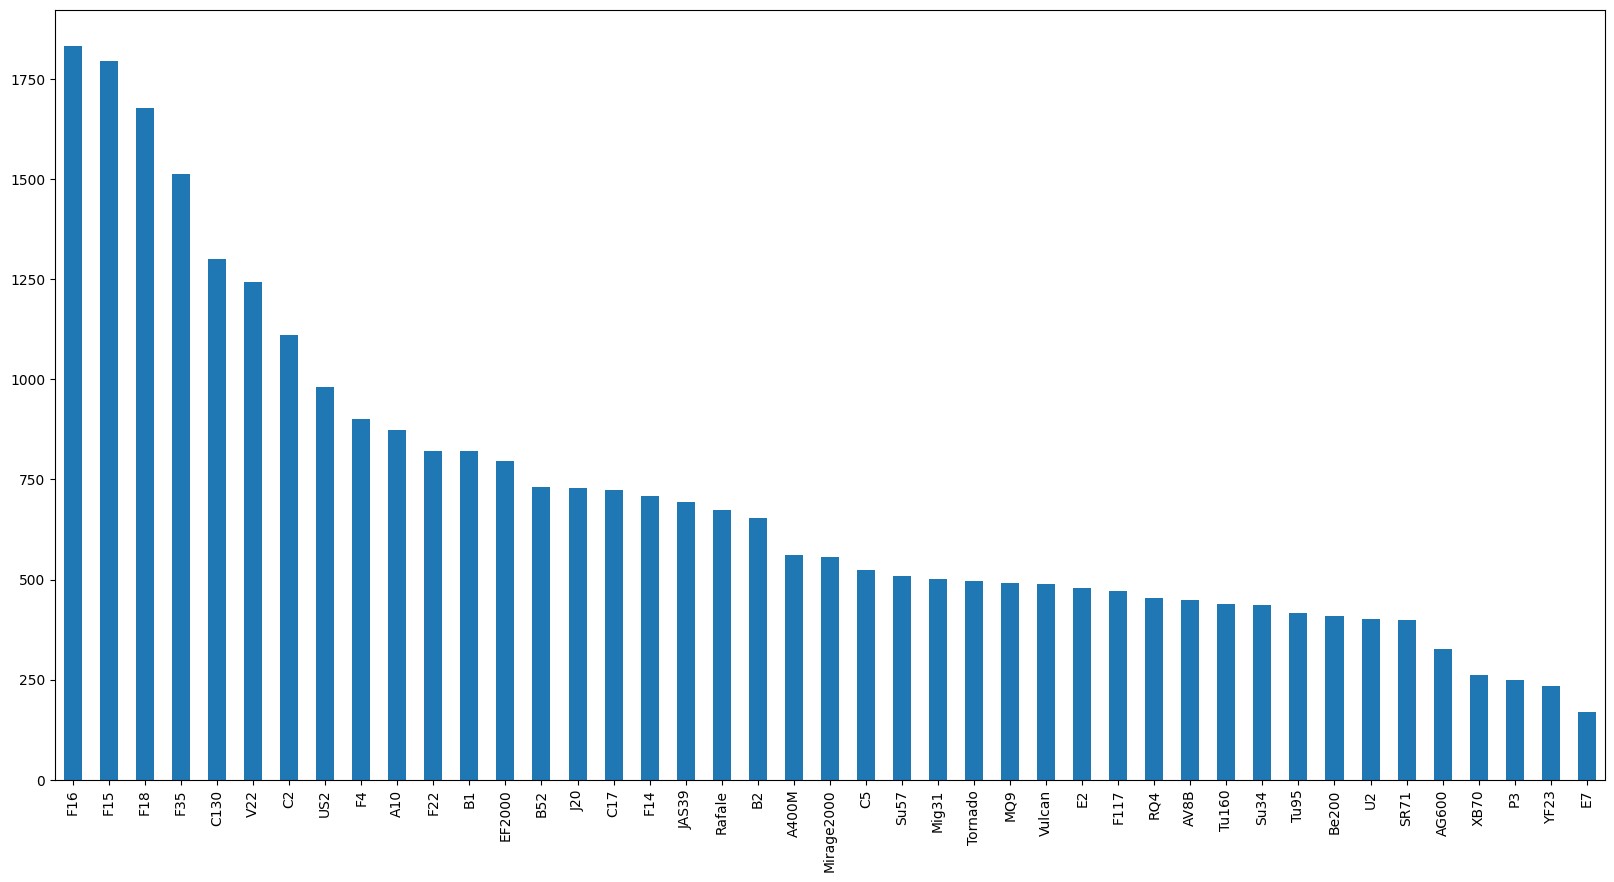

In [10]:
# How many images are there of each class?
df["class"].value_counts().plot.bar(figsize=(20, 10))

** Copy from Google Drive **

Since all of the image already uploaded onto Google Drive, mount the drive on this Colab session, and copy them over to the Colab filesystem. (As my dataset is incredibly large)

In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp -r /content/gdrive/MyDrive/Military\ Aircraft\ Recognition/ /content

Mounted at /content/gdrive


## Split images into train, validation, and test folders
Now that the dataset is uploaded labeled with bounding boxes, lets setup Train-Split-Test folders.

Next, we'll split the images into train, validation, and test sets. Here's what each set is used for:

*   **Train**: These are the actual images used to train the model. In each step of training, a batch of images from the "train" set is passed into the neural network. The network predicts classes and locations of objects in the images. The training algorithm calculates the loss (i.e. how "wrong" the predictions were) and adjusts the network weights through backpropagation.


*   **Validation**: Images from the "validation" set can be used by the training algorithm to check the progress of training and adjust hyperparameters (like learning rate). Unlike "train" images, these images are only used periodically during training (i.e. once every certain number of training steps).


* **Test**: These images are never seen by the neural network during training. They are intended to be used by a human to perform final testing of the model to check how accurate the model is.

Set the each folder accordingly: 80% of the images to the "train" folder, 10% to the "validation" folder, and 10% to the "test" folder. Click play on the following block to download the script and execute it.

In [ ]:
!mkdir /content/images
!unzip -q images.zip -d /content/images/all
!mkdir /content/images/train; mkdir /content/images/validation; mkdir /content/images/test

In [16]:
import os
import shutil
import numpy as np

# Define data directories
base_dir = "/content/Military Aircraft Recognition/"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all image files
all_files = [f for f in os.listdir(base_dir) if f.endswith('.jpg')]

# Shuffle files
np.random.shuffle(all_files)

# Split files (80% train, 10% validation, 10% test)
num_train = int(len(all_files) * 0.8)
num_val = int(len(all_files) * 0.1)

train_files = all_files[:num_train]
val_files = all_files[num_train:num_train+num_val]
test_files = all_files[num_train+num_val:]

# Function to move files
def move_files(files, dst_dir):
    for f in files:
        shutil.move(os.path.join(base_dir, f), os.path.join(dst_dir, f))

# Move files to corresponding directories
move_files(train_files, train_dir)
move_files(val_files, val_dir)
move_files(test_files, test_dir)

print("Data splitting done.")


Data splitting done.


## Create Labelmap and TFRecords

Finally, we need to create a labelmap for the detector and convert the images into a data file format called TFRecords, which are used by TensorFlow for training. We'll use Python scripts to automatically convert the data into TFRecord format. Before running them, we need to define a labelmap for our classes.

In [17]:
### This creates a a "labelmap.txt" file with a list of classes the object detection model will detect.
%%bash
cat <<EOF >> /content/labelmap.txt
A10
A400M
AG600
AV8B
B1
B2
B52
Be200
C2
C5
C17
C130
E2
E7
EF2000
F4
F14
F15
F16
F18
F22
F35
F117
J20
JAS39
Mig31
Mirage2000
MQ9
P3
Rafale
RQ4
SR71
Su34
Su57
Tornado
Tu95
Tu160
U2
US2
V22
Vulcan
XB70
YF23
EOF

Download and run the data conversion scripts from the GitHub repository by clicking play on the following three sections of code. They will create TFRecord files for the train and validation datasets, as well as a labelmap.pbtxt file which contains the labelmap in a different format.

In [35]:
# Download data conversion scripts
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_csv.py
! wget https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_tfrecord.py

--2023-07-01 13:18:54--  https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_csv.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1348 (1.3K) [text/plain]
Saving to: ‘create_csv.py’

create_csv.py       100%[===================>]   1.32K  --.-KB/s    in 0s      

2023-07-01 13:18:54 (68.4 MB/s) - ‘create_csv.py’ saved [1348/1348]

--2023-07-01 13:18:54--  https://raw.githubusercontent.com/EdjeElectronics/TensorFlow-Lite-Object-Detection-on-Android-and-Raspberry-Pi/master/util_scripts/create_tfrecord.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githu

In [36]:
# Create CSV data files and TFRecord files
!python3 create_csv.py
!python3 create_tfrecord.py --csv_input=images/train_labels.csv --labelmap=labelmap.txt --image_dir=images/train --output_path=train.tfrecord
!python3 create_tfrecord.py --csv_input=images/validation_labels.csv --labelmap=labelmap.txt --image_dir=images/validation --output_path=val.tfrecord

Traceback (most recent call last):
  File "/content/models/mymodel/create_csv.py", line 36, in <module>
    main()
  File "/content/models/mymodel/create_csv.py", line 33, in main
    xml_df.to_csv(('images/' + folder + '_labels.csv'), index=None)
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py", line 3720, in to_csv
    return DataFrameRenderer(formatter).to_csv(
  File "/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py", line 1189, in to_csv
    csv_formatter.save()
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/formats/csvs.py", line 241, in save
    with get_handle(
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/common.py", line 734, in get_handle
    check_paren

We'll store the locations of the TFRecord and labelmap files as variables so we can reference them later in this Colab session.

In [20]:
train_record_fname = '/content/train.tfrecord'
val_record_fname = '/content/val.tfrecord'
label_map_pbtxt_fname = '/content/labelmap.pbtxt'

# 4.&nbsp;Set Up Training Configuration

In this section, we'll set up the model and training configuration. We'll specifiy which pretrained TensorFlow model we want to use from the [TensorFlow 2 Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Each model also comes with a configuration file that points to file locations, sets training parameters (such as learning rate and total number of training steps), and more. We'll modify the configuration file for our custom training job.

The first section of code lists out some models availabe in the TF2 Model Zoo and defines some filenames that will be used later to download the model and config file. This makes it easy to manage which model you're using and to add other models to the list later.

Set the "chosen_model" variable to match the name of the model you'd like to train with. It's currently set to use the popular "ssd-mobilenet-v2" model. Click play on the next block once the chosen model has been set.

In [21]:
# Change the chosen_model variable to deploy different models available in the TF2 object detection zoo
chosen_model = 'ssd-mobilenet-v2-fpnlite-320' # the first option is chosen out of the 3 models listed below

MODELS_CONFIG = {
    'ssd-mobilenet-v2': {
        'model_name': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz',
    },
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
    },
    'ssd-mobilenet-v2-fpnlite-320': {
        'model_name': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8',
        'base_pipeline_file': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz',
    },
    # The centernet model isn't working as of 9/10/22
    #'centernet-mobilenet-v2': {
    #    'model_name': 'centernet_mobilenetv2fpn_512x512_coco17_od',
    #    'base_pipeline_file': 'pipeline.config',
    #    'pretrained_checkpoint': 'centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz',
    #}
}

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']

Download the pretrained model file and configuration file by clicking Play on the following section.

In [22]:
# Create "mymodel" folder for holding pre-trained weights and configuration files
%mkdir /content/models/mymodel/
%cd /content/models/mymodel/

# Download pre-trained model weights
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint
!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

# Download training configuration file for model
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/models/mymodel
--2023-07-01 12:38:46--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.171.128, 2607:f8b0:4001:c5f::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.171.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20515344 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.56M  --.-KB/s    in 0.1s    

2023-07-01 12:38:47 (140 MB/s) - ‘ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz’ saved [20515344/20515344]

--2023-07-01 12:38:47--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 

Now that we've downloaded our model and config file, we need to modify the configuration file with some high-level training parameters. The following variables are used to control training steps:

* **num_steps**: The total amount of steps to use for training the model. A good number to start with is 40,000 steps. You can use more steps if you notice the loss metrics are still decreasing by the time training finishes. The more steps, the longer training will take. Training can also be stopped early if loss flattens out before reaching the specified number of steps.
* **batch_size**: The number of images to use per training step. A larger batch size allows a model to be trained in fewer steps, but the size is limited by the GPU memory available for training. With the GPUs used in Colab instances, 16 is a good number for SSD models and 4 is good for EfficientDet models.

Other training information, like the location of the pretrained model file, the config file, and total number of classes are also assigned in this step. To learn more about training configuration with the TensorFlow Object Detection API, read this [article from Neptune](https://neptune.ai/blog/tensorflow-object-detection-api-best-practices-to-training-evaluation-deployment).

In [26]:
# Set training parameters for the model
num_steps = 40000

if chosen_model == 'efficientdet-d0':
  batch_size = 4
else:
  batch_size = 16

In [30]:
# Set file locations and get number of classes for config file
pipeline_fname = '/content/models/mymodel/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/mymodel/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(label_map_pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(label_map_pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())
num_classes = get_num_classes(label_map_pbtxt_fname)
print('Total classes:', num_classes)

NotFoundError: ignored